# Rivet style analysis plots in MATPLOTLIB

Easier way to do rivet style final state analysis when only plots required are the final state variables/kinematics.  Requires pyhepmc (a python binding for hepmc from c++) and matplotlib.pyplot.

Data used can be found [Here](https://opendata.cern/record/160002) - Specifically the file named HEPMC.43646139._000001.tar.gz.1 under the list.

The Baler reconstructed 4momenta is found in "".decompressed.npz"" and the notebook to reconstuct these into a HEPMC file is "write_final_state_momenta.ipynb".

The config to run Baler is found under configs as baler_configs_1.py, although the epoches can be reduced to around 200 for 99.99% of the results

In [37]:
import os, sys
import importlib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "scripts") ))

from dataclasses import dataclass, field
from typing import Tuple, List, Union, Callable, Dict, Any

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import PowerTransformer
import pyhepmc 
from pyhepmc import GenEvent, FourVector, GenParticle
from pyhepmc.io import ReaderAsciiHepMC2, WriterAsciiHepMC2

import event_cuts
import hepmc_configs
import calc_variables

from hepmc_configs import HistConfigurations
from event_cuts import CutConfigurations, EventCuts

First define functions for the logic of the final state particles that returns the final state particles and another for reading the input file(s) and retrieveing and store the 4-momentum of all final state particles. 

Functions used as read_get_final_states() with the arguments either a str to a file or a list of strings to files -> If used as a list of strings it concatinates the results back into one list, so if want to use for comparing two distriubtions have to call it seperately on the seperate files.

In [38]:
def final_state_logic(event : GenEvent) -> List[GenParticle]:
    """Given an input of a GenEvent from a HEPMC introduces the logic to find the 2 final state electrons 
        from the Drell-Yan Z -> ee process. Very simple logic requiring a Z boson with 2 final state electrons
        coming from its end vertex.
    """
    e_pair = list()
    for particles in event.particles:
        # Check for Z boson
        if particles.pid == 23:
            end_vertex = particles.end_vertex
            if end_vertex.particles_out is None:
                continue
            # Loop through daughters of its end vertex
            for daughter_particles in end_vertex.particles_out:
                if abs(daughter_particles.pid) == 11 and daughter_particles.status == 1:
                    e_pair.append(daughter_particles)
    momentum_array = [e_pair[0].momentum.px,e_pair[0].momentum.py,e_pair[0].momentum.pz,e_pair[0].momentum.e
                      ,e_pair[1].momentum.px,e_pair[1].momentum.py,e_pair[1].momentum.pz,e_pair[1].momentum.e]
    return momentum_array

def read_hepmc_file_get_final_states(input_file: str) -> List[List[GenParticle]]:
    """Function to read a single hepmc file, read all the events and extact
        the final state electron pairs from each event.
        Args:    
            input_file (str) : name/location of input file
        Returns:
            List[List[GenParicle]]: Each list entry is a list of GenParitcles 
                from a singular event.
    """
    # Create pyhepmc GenEvent to be able to read in the Event Gen
    event = GenEvent()
    electron_pairs = []
    with ReaderAsciiHepMC2(input_file) as reader:
        # Continues untill all events are read, if a standarad open data single 
        # file this would be 10,000 events
        while not reader.failed():
            if reader.failed():
                break
            reader.read_event(event)

            candidate_pair = final_state_logic(event)
            # Stop empty events appending
            if candidate_pair:
                electron_pairs.append(candidate_pair)
    return electron_pairs

def read_get_final_states(input_files: Union[str, List[str]]) -> List[Tuple[GenParticle]]:
    """Function that either reads in a Lit of strings or a string of a file name 
        that corresponds to a HEPMC - no name checking logic involved as 
        reader in read_hepmc_file will fail if it is not anyway
        Args:
            input_files : either a str or a list of strings
        Returns:
            List[List[GenParicle]]: Each list entry is a list of GenParitcles 
            from a singular event.
    """
    ## This ensures the logic is the same for either string or list input
    files = input_files if isinstance(input_files, list) else [input_files]

    four_momenta = []
    
    for file in files:
        four_momenta += read_hepmc_file_get_final_states(file)
    return four_momenta

def read_momenta_from_npz(file_to_read):
    """Function to recieve the momenta vectors from a Baler style npz"""
    file_object = np.load(file_to_read)
    return file_object["data"]

Now that we have the functions to read the files and get the final state particles we know need functions to easily make plots.

First we will get the particle sof both the original and reconstructed particles.

In [ ]:
#original_particles = read_get_final_states( "../DATA/HEPMC.43646139._000001.hepmc")
#reconstructed_particles = read_get_final_states("../processedData/reinputed_final_state.hepmc")

original_particles = read_momenta_from_npz("../DATA/MomentumOrdered100-000Events20ParticlesFlattened.npz")
reconstructed_particles = read_momenta_from_npz("../balercompressionexperiments/20eventsbiggerAEnormalised3000ecpohes/BiggerAE.npz")


In [50]:
print(original_particles.shape)
print(reconstructed_particles.shape)

(100000, 80)
(100000, 80)


Next we will define classes for PlotConfigurables and a function to plot both the distribution histogram and the ratio histrogram.

The make_invariant_mass_plots is first hard encoded to produce a plot for the invariant mass of the system, and can be called with the lists produced from read_get_final_states(), with either a len 2 list or as just the result from the read_get_final_states, if the former you get two overlapped distrubtions and a ratio plot, if the latter you get just the distribution of that set.

In [41]:
## To do make one of the arguments a function that returns the desired quantity for plotting.
def make_distribution_plots(particle_lists: List[List[float]], 
                                variable_function, 
                                config: HistConfigurations,
                                cut_config: CutConfigurations = None) -> None:
    """ Function to create histogram plots using distributions, either takes 1 or 2 
    particle lists as input, if 1 produces a singular plot of a histogram, if 2 makes overlapping
    histogram plots on top panel and ratio plot on the smaller bottom panel.

    Calculates invariant mass of each lepton pair and stores in an array.

    If one input so particle_list[0][0] is a GenParticle turn into a list of lists of lists for 
    homogenity.

    """

    # Check number of distributions
    if particle_lists is None:
        raise AttributeError("Particle list is empty")
    if isinstance(particle_lists[0][0], float):
        raw_particle_lists = [particle_lists]
        num_dist = 1
    else:
        if len(particle_lists) > 2:
            raise AttributeError("Maximum 2 distibutions allowed")
        raw_particle_lists = particle_lists
        num_dist = 2
    raw_particle_lists = np.array(raw_particle_lists)
    print(raw_particle_lists.shape)
    if cut_config:
        event_cutter = EventCuts(**{"cut_config" : cut_config})
        event_cutter.fit_cuts(raw_particle_lists[1])
        raw_particle_lists = event_cutter.make_cuts(raw_particle_lists)
    print(raw_particle_lists.shape)
    # Catch if an try except block as can't do get_attr on the notebook.
    try:
        variable_distributions = variable_function(raw_particle_lists)
    except:
        raise NameError(f"{variable_function} : function does not exist")
    
    # Create figure and add title
    fig = plt.figure(figsize = config.figsize)
    plt.suptitle(config.title)
    print(variable_distributions[0].shape)
    # If compare of singular
    if num_dist == 1:
        pass
    else:
        gs = fig.add_gridspec(2, 1, height_ratios=config.height_ratios, hspace=0)
        
        ax_top = fig.add_subplot(gs[0])
        ax_bot = fig.add_subplot(gs[1], sharex=ax_top)

        # Removes ticks from the top plot
        ax_top.tick_params(axis='x',
                   labelbottom=False, 
                   labeltop=False) 


        # Save bin counts of each and bin_edges once for ratio plot
        (first_bins, bin_edges, _) = ax_top.hist(variable_distributions[0],
                    bins = config.bins,
                    range = config.range,
                    histtype=config.hist_type,
                    label = config.label)
        (second_bins, _ , _) = ax_top.hist(variable_distributions[1], 
                    bins = config.bins,
                    range = config.range,
                    histtype=config.hist_type,
                    label = config.label_two)
        
        # Calculate ratios and the values of x to plot at 
        bin_ratios = [f_b / s_b if s_b > 0 else np.nan for (f_b, s_b) in zip(first_bins, second_bins)]
        plotting_x = [(bin_edges[i+1] + bin_edges[i])/2  for i in range(0, len(bin_edges) - 1)]
        
        ax_bot.scatter(x = plotting_x, y = bin_ratios, marker = "x")

        # Plot configurables
        if config.legend:
            ax_top.legend()


        ax_bot.set_xlabel(config.xlabel)
        if config.use_range_over_bin_y_label:
            range_over_bin = f"per {abs((config.range[1] -  config.range[0])/config.bins)} MeV"
        else:
            range_over_bin = ""
            
        ax_top.set_ylabel(config.ylabel + range_over_bin)
        ax_bot.set_xscale(config.x_scale)
        ax_top.set_yscale(config.y_scale)
        ax_bot.set_ylabel(
                            config.ratio_y_label,
                            rotation = config.ratio_y_rotation,
                            size = config.ratio_y_size,
                            labelpad= config.ratio_y_pad
                        )
     
        ax_bot.set_xlim(config.range) 
        plt.show() 
    if config.to_plot_scatter:
        fig, ax = plt.subplots(figsize=(8, 6))

        # Scatter plot: original (x) vs reconstructed (y)
        ax.scatter(
            variable_distributions[1],   # Original (x-axis)
            variable_distributions[0],   # Reconstructed (y-axis)
            marker="o",
            s=30,                        # Marker size
            c="blue",                    # Marker color
            alpha=0.6,                   # Transparency for overlap
            label="Reconstructed vs Original"
        )

        ax.scatter(
            variable_distributions[1],  
            variable_distributions[1],  # Original vs Original (reference layer)
            marker="x",
            s=25,
            c="red",
            alpha=0.4,
            label="Original Reference"
        )

        # Add a y=x reference line
        min_val = min(np.min(variable_distributions[0]), np.min(variable_distributions[1]))
        max_val = max(np.max(variable_distributions[0]), np.max(variable_distributions[1]))
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1.2, label="Ideal y=x")

        # Style and labels
        ax.set_xlabel("Original Quantity", fontsize=12)
        ax.set_ylabel("Reconstructed Quantity", fontsize=12)
        ax.set_title(config.scatter_title)
        ax.grid(True, linestyle="--", alpha=0.7)
        ax.legend()

        plt.tight_layout()
        plt.show()
    

Now producing a simple plot of the reconstructed vs original dilepton invariant masses. 

In [51]:
cut_config = CutConfigurations()
cut_config.add_cut(event_cuts.TransverseMomentumCut, pt0_lower=25000,  pt1_lower=20000)
cut_config.add_cut(event_cuts.EtaCut)

(2, 100000, 80)
(2, 86998, 80)
(86998,)


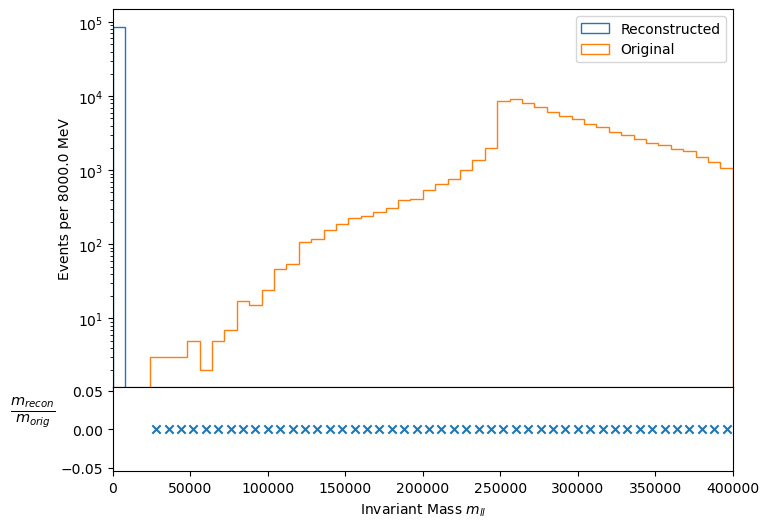

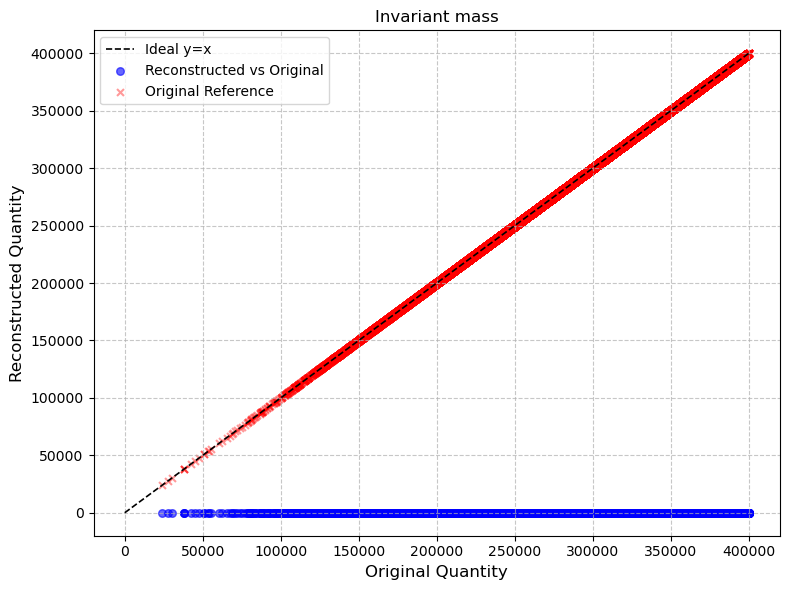

In [52]:
invariant_mass_config = HistConfigurations(r"Invariant Mass $m_{ll}$",  r"Events ", "",
                                           legend = True, range = (0, 400_000),
                                           label = "Reconstructed", label_two = "Original",
                                           bins = 50, 
                                           ratio_y_label = r"$\frac{m_{recon}}{m_{orig}}$",
                                           to_plot_scatter = True,
                                           scatter_title = r"Invariant mass")

make_distribution_plots([reconstructed_particles, original_particles], calc_variables.calc_invariant_mass, invariant_mass_config, cut_config=cut_config)

(2, 100000, 80)
(2, 86998, 80)
(2, 173996)
(173996,)


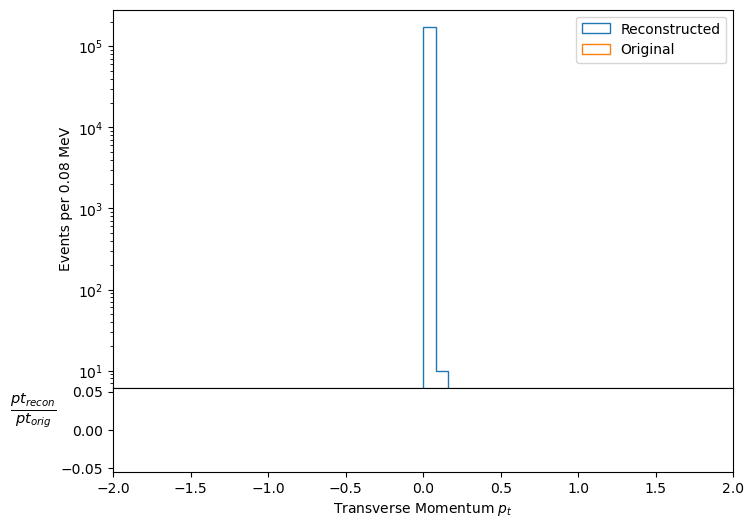

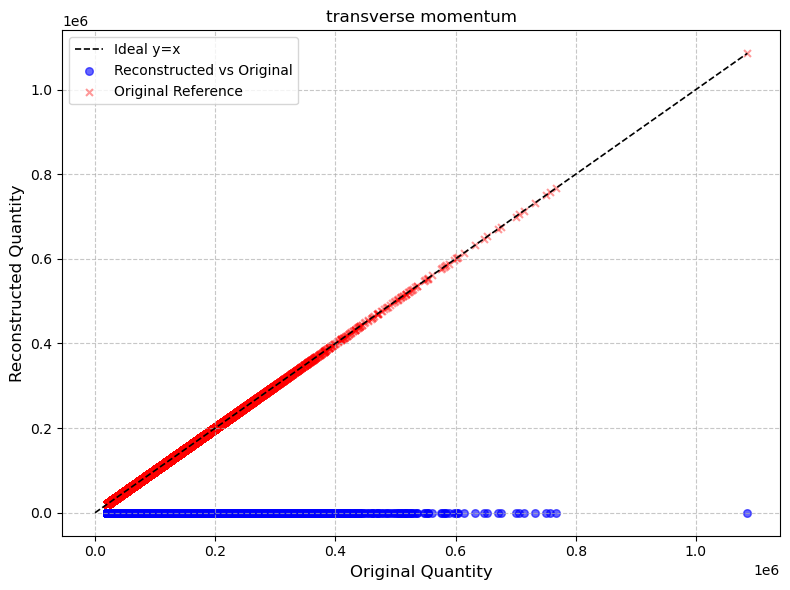

In [ ]:
transvere_momentum_config = HistConfigurations(r"Transverse Momentum $p_t$",  r"Events ", "",
                                           legend = True, range = (0, 400_000),
                                           label = "Reconstructed", label_two = "Original",
                                           bins = 50, 
                                           
                                           ratio_y_label = r"$\frac{pt_{recon}}{pt_{orig}}$",
                                           to_plot_scatter = True,
                                           scatter_title = "transverse momentum")

make_distribution_plots([reconstructed_particles, original_particles], calc_variables.calc_transverse_momentum, transvere_momentum_config, cut_config=cut_config)

(2, 100000, 80)
(2, 86998, 80)
(173996,)


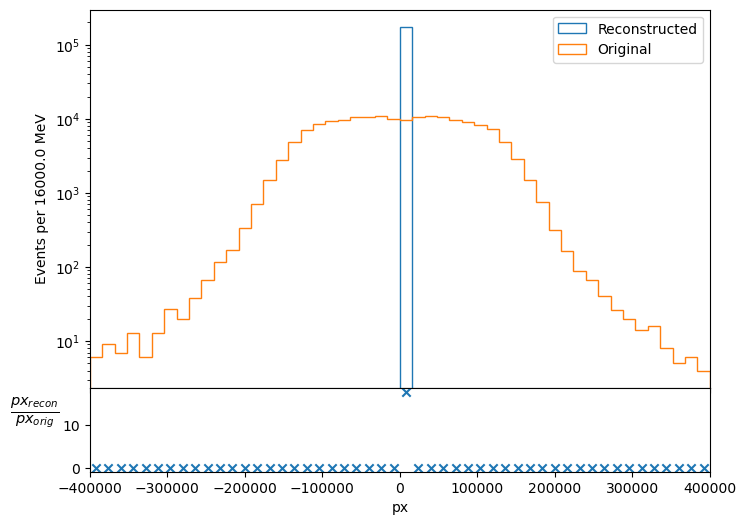

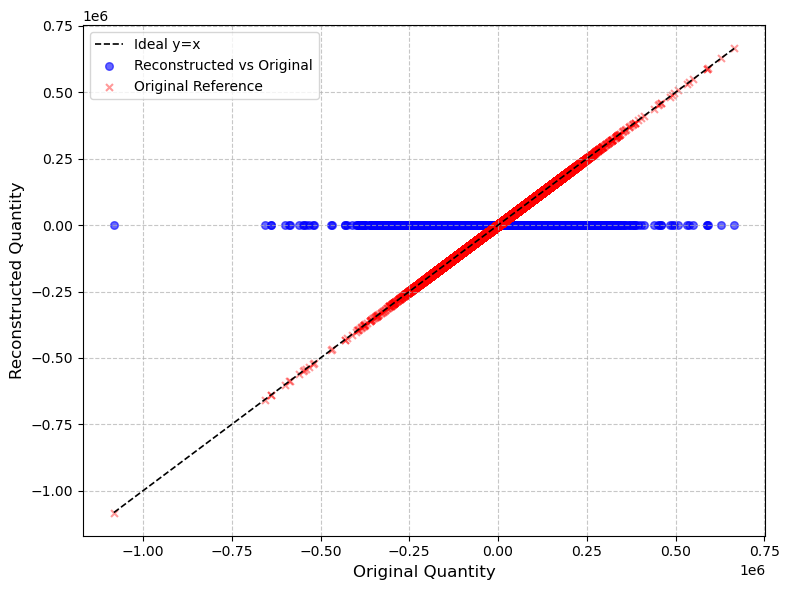

In [45]:
energy_config = HistConfigurations(r"px",  r"Events ", "",
                                           legend = True, range = (-400000, 400_000),
                                           label = "Reconstructed", label_two = "Original",
                                           bins = 50, 
                                           ratio_y_label = r"$\frac{px_{recon}}{px_{orig}}$",
                                           to_plot_scatter = True)

make_distribution_plots([reconstructed_particles, original_particles], calc_variables.calc_px, energy_config, cut_config=cut_config)

(2, 100000, 80)
(2, 86998, 80)
(86998,)


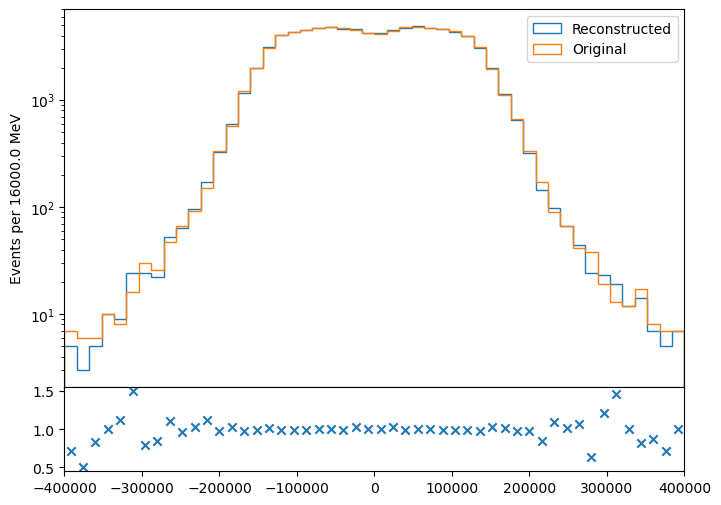

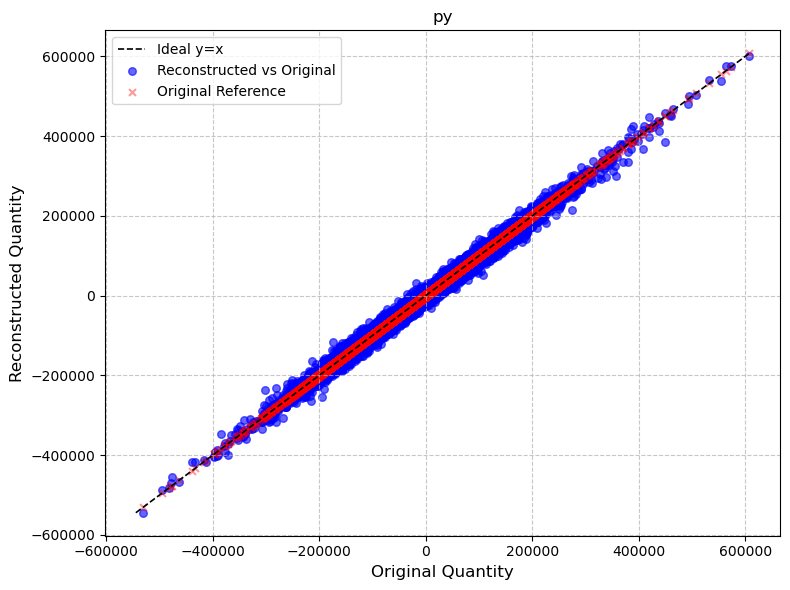

In [46]:
energy_config = HistConfigurations(r"",  r"Events ", "",
                                           legend = True, range = (-400000
                                                                   , 400_000),
                                           label = "Reconstructed", label_two = "Original",
                                           bins = 50, 
                                           ratio_y_label = "",
                                           to_plot_scatter = True,
                                           scatter_title = r"py")

make_distribution_plots([reconstructed_particles, original_particles], calc_variables.get_py_0, energy_config, cut_config = cut_config)

(2, 100000, 80)
(2, 86998, 80)
(86998, 1)


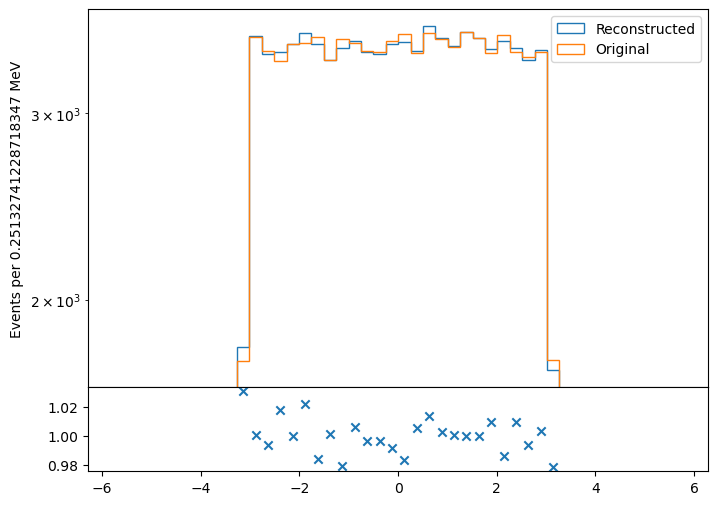

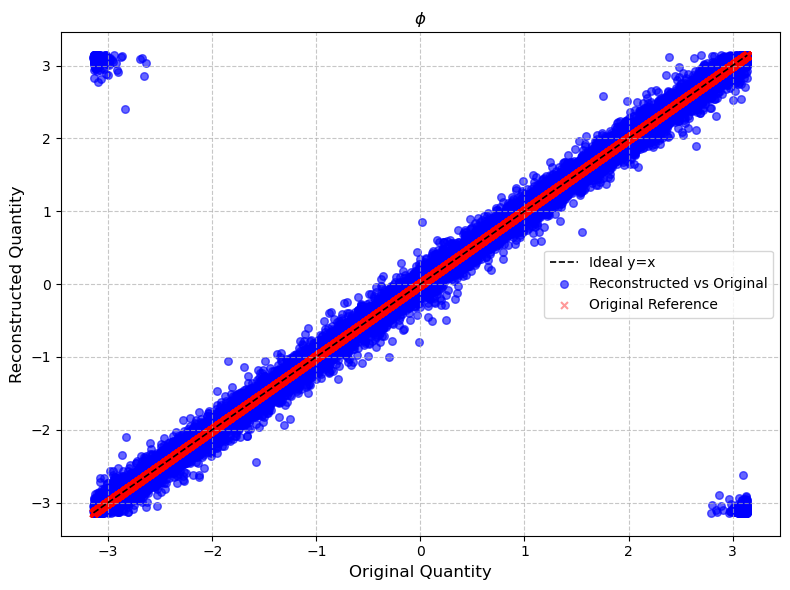

In [47]:
energy_config = HistConfigurations(r"",  r"Events ", "",
                                           legend = True, range = (- 2 * np.pi
                                                                   , 2 * np.pi),
                                           label = "Reconstructed", label_two = "Original",
                                           bins = 50, 
                                           ratio_y_label = "",
                                           to_plot_scatter = True,
                                           scatter_title = r"$\phi$")

make_distribution_plots([reconstructed_particles, original_particles], calc_variables.calc_phi_0, energy_config, cut_config = cut_config)

(2, 100000, 80)
(2, 86998, 80)
(86998, 1)


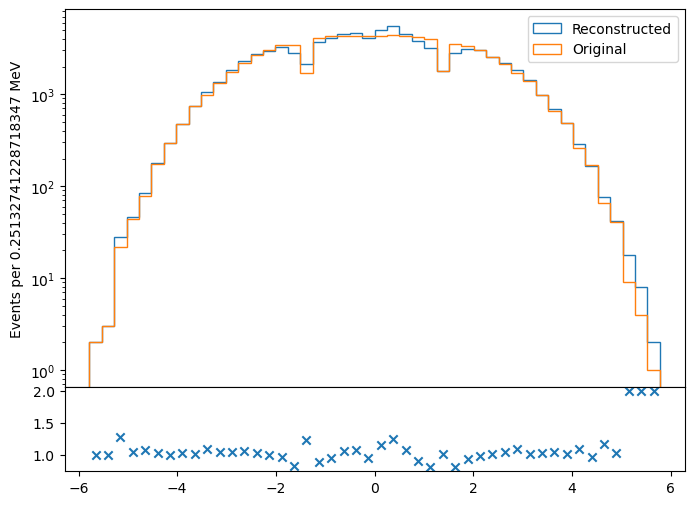

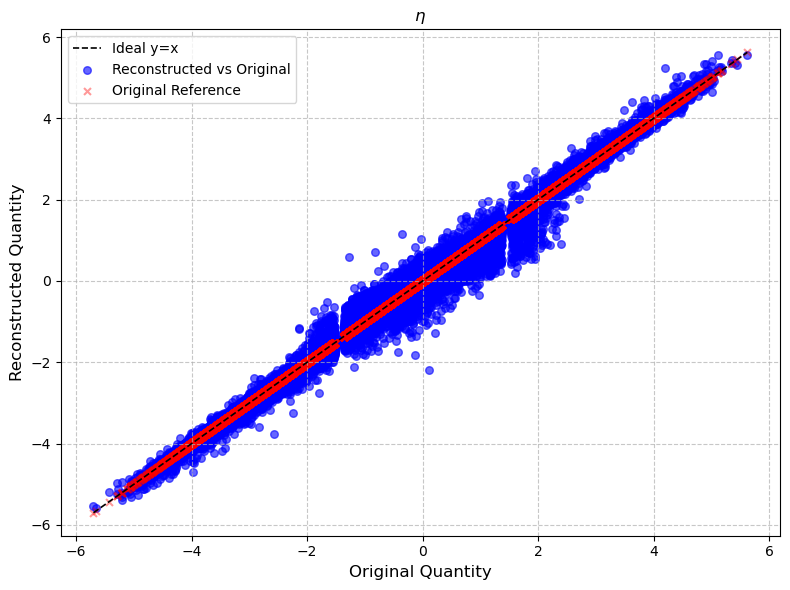

In [48]:
energy_config = HistConfigurations(r"",  r"Events ", "",
                                           legend = True, range = (- 2 * np.pi
                                                                   , 2 * np.pi),
                                           label = "Reconstructed", label_two = "Original",
                                           bins = 50, 
                                           ratio_y_label = "",
                                           to_plot_scatter = True,
                                           scatter_title = r"$\eta$")

make_distribution_plots([reconstructed_particles, original_particles], calc_variables.calc_eta_0, energy_config, cut_config = cut_config)